# CLIP-Dissect
**Keywords**: Neuron-level Interpretability, Network Dissection

**About the dataset**:

* We use the standard [CIFAR100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) here which contains 60k RGB images of size $32\times 32$ belonging to 100 classes.

**Agenda**:

* In this programming challenge, we will answer the following questions.
  * Let's dissect resnet 50 layer 1 and 4 similar to what we did on the last layer neuron.
      - Does the neuron description match the highly activated images? How many of them describe well / not so well but relevant / not accurate?  
      - Please think of a way to manage / save the result for future analysis.  


**Note:**
* A note on working with GPU:
  * Take care that whenever declaring new tensors, set `device=device` in parameters.
  * You can also move a declared torch tensor/model to device using `.to(device)`.
  * To move a torch model/tensor to cpu, use `.to('cpu')`
  * Keep in mind that all the tensors/model involved in a computation have to be on the same device (CPU/GPU).
* Run all the cells in order.
* **Do not edit** the cells marked with !!DO NOT EDIT!!
* Only **add your code** to cells marked with !!!! YOUR CODE HERE !!!!
* Do not change variable names, and use the names which are suggested.

In [1]:
# !!DO NOT EDIT!!
!git clone https://github.com/Trustworthy-ML-Lab/CLIP-dissect
!pip install ftfy regex

Cloning into 'CLIP-dissect'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 98 (delta 10), reused 9 (delta 7), pack-reused 80
Receiving objects: 100% (98/98), 15.90 MiB | 29.33 MiB/s, done.
Resolving deltas: 100% (31/31), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00


In [2]:
import os
os.chdir('CLIP-dissect')

In [3]:
import torch
import pandas as pd

import clip
import utils
import data_utils
import similarity

import matplotlib
from matplotlib import pyplot as plt

import csv

In [4]:
# Settings
clip_name = 'ViT-B/16'
target_name = 'resnet50'
# target_layers = ['layer1', 'layer2', 'layer3', 'layer4']
d_probe = 'cifar100_train'
concept_set = 'data/imagenet_labels.txt'
batch_size = 200
device = 'cuda'
pool_mode = 'avg'

save_dir = 'saved_activations'
similarity_fn = similarity.soft_wpmi

First, run the below code with the commented out lines uncommented (save to csv section) and without limiting which neurons are checked to create a csv file of all the labels in the respective layer. Then re-comment out the lines and print out ~100 neurons at a time to check if the labels are accurate.

100%|███████████████████████████████████████| 335M/335M [00:07<00:00, 47.5MiB/s]
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 84.0MB/s]


100%|██████████| 169001437/169001437 [00:05<00:00, 31378279.73it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache
Files already downloaded and verified


100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 250/250 [02:33<00:00,  1.63it/s]


Files already downloaded and verified


100%|██████████| 512/512 [00:00<00:00, 1425.71it/s]


torch.Size([512, 1000])


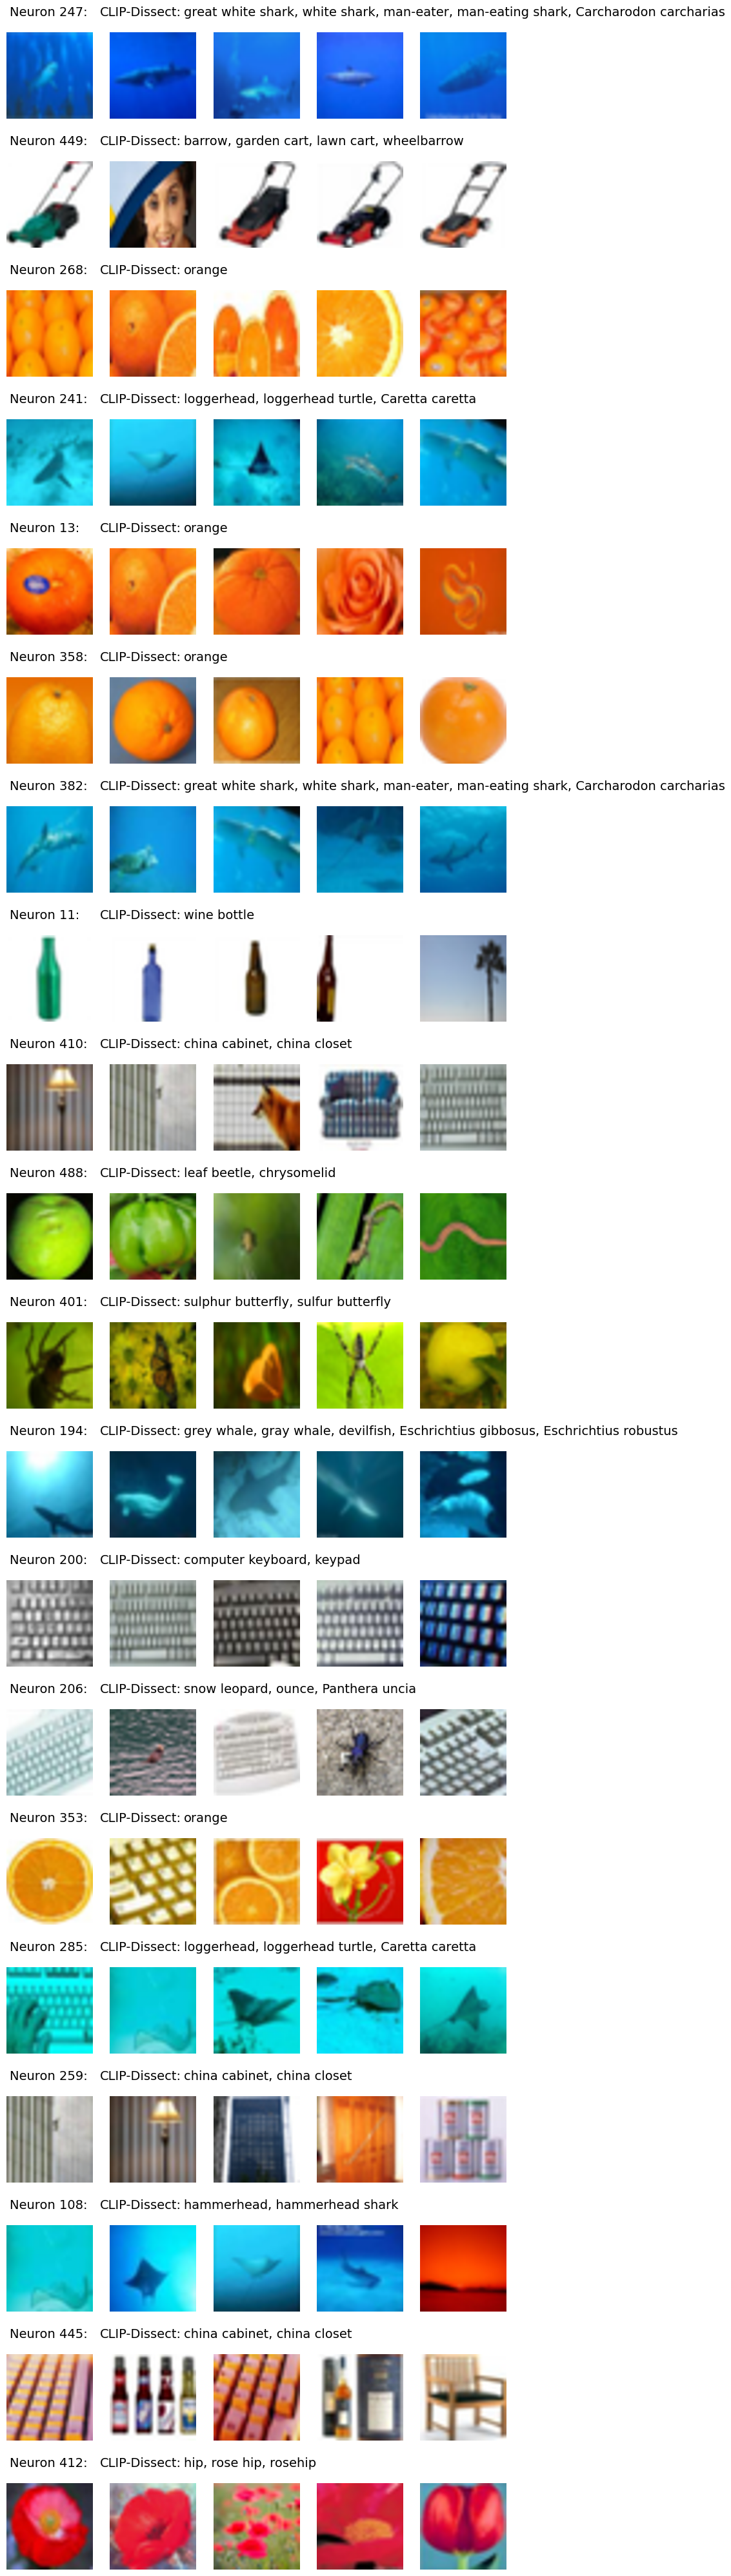

In [5]:
# Set layer to Layer 2
target_layer = 'layer2'

# Run CLIP-Dissect
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names
similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                                text_save_name, similarity_fn, device=device)

# Visualize
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)
neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:20]
font_size = 14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
# labels2 = []
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
    # labels2.append([words[int(ids[0])]])

    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')

# with open('labels2', 'w') as f:

#     # using csv.writer method from CSV package
#     write = csv.writer(f)

#     write.writerows(labels2)

plt.show()

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 250/250 [02:35<00:00,  1.61it/s]


Files already downloaded and verified


100%|██████████| 1024/1024 [00:01<00:00, 600.97it/s]


torch.Size([1024, 1000])


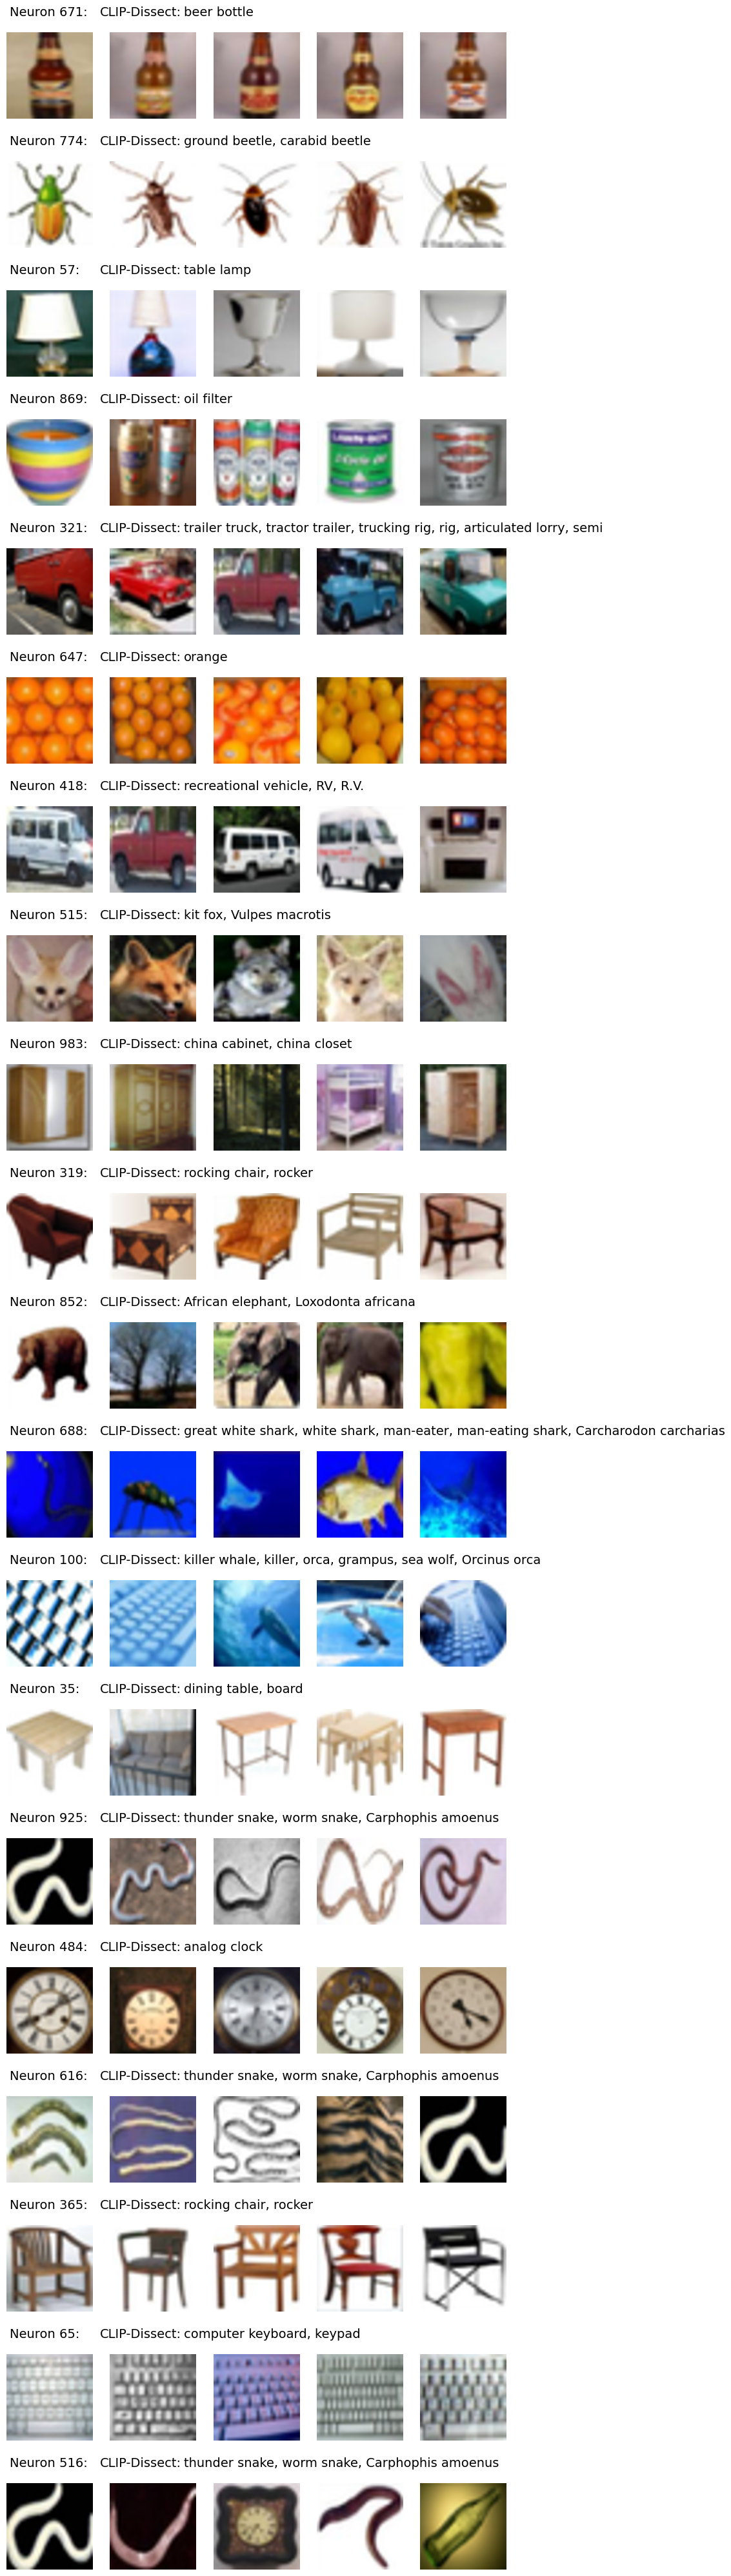

In [6]:
# Set layer to Layer 3
target_layer = 'layer3'

# Run CLIP-Dissect
utils.save_activations(clip_name = clip_name, target_name = target_name, target_layers = [target_layer],
                       d_probe = d_probe, concept_set = concept_set, batch_size = batch_size,
                       device = device, pool_mode=pool_mode, save_dir = save_dir)

with open(concept_set, 'r') as f:
    words = (f.read()).split('\n')

pil_data = data_utils.get_data(d_probe)

save_names = utils.get_save_names(clip_name = clip_name, target_name = target_name,
                                  target_layer = target_layer, d_probe = d_probe,
                                  concept_set = concept_set, pool_mode=pool_mode,
                                  save_dir = save_dir)

target_save_name, clip_save_name, text_save_name = save_names
similarities, target_feats = utils.get_similarity_from_activations(target_save_name, clip_save_name,
                                                                text_save_name, similarity_fn, device=device)

# Visualize
top_vals, top_ids = torch.topk(target_feats, k=5, dim=0)
neurons_to_check = torch.sort(torch.max(similarities, dim=1)[0], descending=True)[1][0:20]
font_size = 14
font = {'size'   : font_size}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=[10, len(neurons_to_check)*2])#constrained_layout=True)
subfigs = fig.subfigures(nrows=len(neurons_to_check), ncols=1)
# labels3 = []
for j, orig_id in enumerate(neurons_to_check):
    vals, ids = torch.topk(similarities[orig_id], k=5, largest=True)
    # labels3.append([words[int(ids[0])]])

    subfig = subfigs[j]
    subfig.text(0.13, 0.96, "Neuron {}:".format(int(orig_id)), size=font_size)
    subfig.text(0.27, 0.96, "CLIP-Dissect:", size=font_size)
    subfig.text(0.4, 0.96, words[int(ids[0])], size=font_size)
    axs = subfig.subplots(nrows=1, ncols=5)
    for i, top_id in enumerate(top_ids[:, orig_id]):
        im, label = pil_data[top_id]
        im = im.resize([375,375])
        axs[i].imshow(im)
        axs[i].axis('off')

# with open('labels3', 'w') as f:

#     # using csv.writer method from CSV package
#     write = csv.writer(f)

#     write.writerows(labels3)

plt.show()

---
---